In [330]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


# Project-4. Bank Scoring.

In [331]:
from pandas import Series
import pandas as pd
import numpy as np
import math


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import auc, roc_auc_score, roc_curve

import datetime
from datetime import datetime, timedelta

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [332]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
scor_train = pd.read_csv(DATA_DIR+'/train.csv')
scor_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [333]:
scor_train.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


In [334]:
scor_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [335]:
scor_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [336]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
scor_train['sample'] = 1 # помечаем где у нас трейн
scor_test['sample'] = 0 # помечаем где у нас тест
scor_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, поэтому пока просто заполняем нулями

scor = scor_test.append(scor_train, sort=False).reset_index(drop=True) # объединяем

In [337]:
sample_submission.head(3)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370


In [338]:
scor.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0


In [339]:
scor.shape

(110148, 20)

In [340]:
scor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Пропуски, как и в учебном датасете, только в 'education'. Заполняем их значением 'SCH'

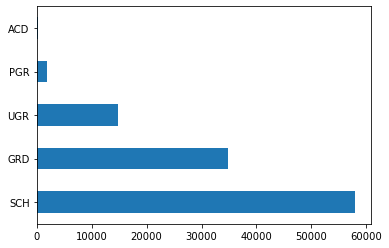

In [341]:
scor.education.value_counts().plot.barh()

In [342]:
scor.education.fillna('SCH', inplace=True)
scor.education.isna().value_counts()

False    110148
Name: education, dtype: int64

# 1. Рассмотрим подробнее новые признаки

1. 'sna' - категориальный признак, имеет 4 числовые категории

In [343]:
scor.sna.value_counts()

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

2. 'first_time' - категориальный признак, имеет так же 4 числовые категории

In [344]:
scor.first_time.value_counts()

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

3. 'score_bki' - численный признак

In [345]:
scor.score_bki.describe()

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

Сдвинем значения этого признака в положительную зону и посмотрим графики

In [346]:
scor['score_bki'] -= scor['score_bki'].min()
scor.score_bki.describe()

count    110148.000000
mean          1.720051
std           0.499397
min           0.000000
25%           1.364153
50%           1.703763
75%           2.056698
max           3.824359
Name: score_bki, dtype: float64

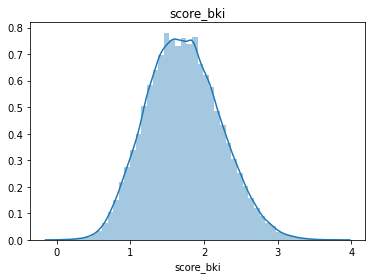

In [347]:
plt.figure()
sns.distplot(scor['score_bki'])
plt.title('score_bki')
plt.show()

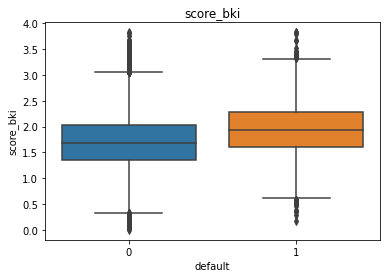

In [348]:
plt.figure()
sns.boxplot(x = scor.default, y = scor['score_bki'])
plt.title('score_bki')
plt.show()

Выводы из графиков: признак 'score_bki' распределен нормально, медиана по дефолтным клиентам выше,
выбросы есть с стороны обоих хвостов. Удалять выбросы пока не будем. 

4. 'region_rating' - категориальный признак, имеет 7 числовых категорий

In [349]:
scor.region_rating.value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

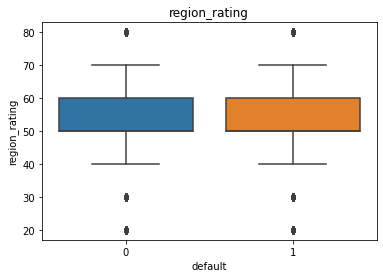

In [350]:
plt.figure()
sns.boxplot(x = scor.default, y = scor['region_rating'])
plt.title('region_rating')
plt.show()

5. 'app_date' - дата подачи заявки. 120 уникальных значений, преобразуем их в формат datetime в новом столбце 'app_datetime'. Можно будет на его основе создать новые признаки, например, день недели.

In [351]:
scor.app_date.describe()

count        110148
unique          120
top       18MAR2014
freq           1491
Name: app_date, dtype: object

In [352]:
scor['app_datetime'] = scor['app_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [353]:
scor.app_datetime[:3]

0   2014-03-22
1   2014-01-24
2   2014-03-23
Name: app_datetime, dtype: datetime64[ns]

Выводы по новым признакам: к учебному датасету добавлены 3 категориальных, 1 численный и 1 признак-дата.
Пропусков нет. Выбросы у численного пока не убираем. Создадим на основе признака-даты  и численного еще пару новых признаков и включим все вместе в анализ основных переменных.

# 2. Feature engineering

2.1 Создадим признак 'app_weekday', может, дефолтные клиенты приходят чаще в пн, например. Это будет категориальный признак. 

In [354]:
scor['app_weekday'] = scor['app_datetime'].apply(lambda x: x.weekday())
scor['app_weekday'][:3]

0    5
1    4
2    6
Name: app_weekday, dtype: int64

Еще создадим признак 'days_from_start_day' - кол-во дней с начала учета данных, отнесем его к численным

In [355]:
start_day = scor.app_datetime.min()
scor['days_from_start_day'] = (scor.app_datetime - start_day).dt.days.astype('int')

2.2 Создадим полиномиальные новые признаки на основе двух числовых 'income' и 'decline_app_cnt' 

In [356]:
pf = PolynomialFeatures(3)
poly_features = pf.fit_transform(scor[['score_bki', 'bki_request_cnt']])
poly = pd.DataFrame(poly_features).drop([0,1,2,3,5,6,9], axis = 1)
poly.columns = ['score_bki_request4', 'score_bki_request7', 'score_bki_request8']
scor = pd.concat([scor, poly], axis=1)
poly.shape

(110148, 3)

In [357]:
poly.head(3)

,score_bki_request4,score_bki_request7,score_bki_request8
0,4.058108,5.489413,12.174324
1,4.239174,8.985300,8.478349
2,1.933247,3.737445,1.933247


2.3 Создадим полиномиальные новые признаки на основе двух числовых 'score_bki' и 'decline_app_cnt'

In [358]:
pf = PolynomialFeatures(3)
poly_features = pf.fit_transform(scor[['score_bki', 'decline_app_cnt']])
poly = pd.DataFrame(poly_features).drop([0,1,2,3,5,6,9], axis = 1)
poly.columns = ['score_decline4', 'score_decline7', 'score_decline8']
scor = pd.concat([scor, poly], axis=1)

Итог: создано 7 численных и 1 категориальный новый признак

# 3. Анализ признаков

In [359]:
scor.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default', 'app_datetime',
       'app_weekday', 'days_from_start_day', 'score_bki_request4',
       'score_bki_request7', 'score_bki_request8', 'score_decline4',
       'score_decline7', 'score_decline8'],
      dtype='object')

Сгруппируем признаки по типам

In [360]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki',
           'score_bki_request4', 'score_bki_request7', 'score_bki_request8',
           'score_decline4', 'score_decline7', 'score_decline8', 'days_from_start_day']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 
            'sna', 'first_time', 'region_rating', 'app_weekday']

# 3.1 Анализ численных признаков

In [361]:
num_cols_short = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki','days_from_start_day']           

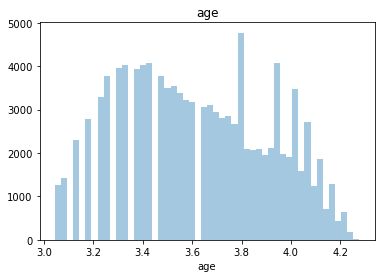

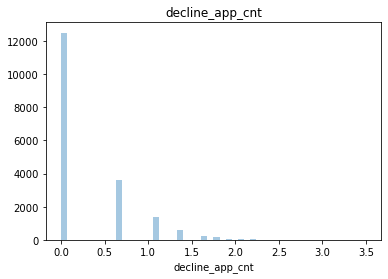

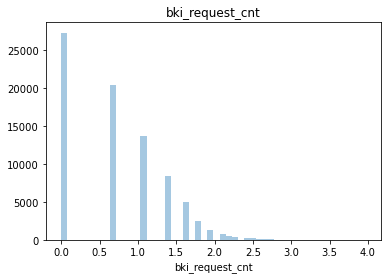

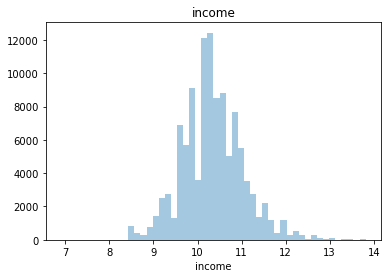

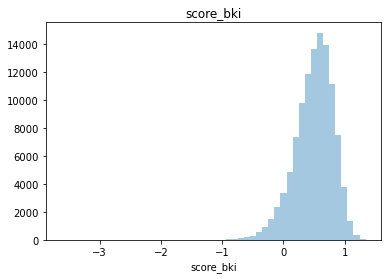

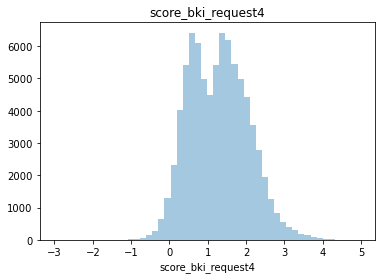

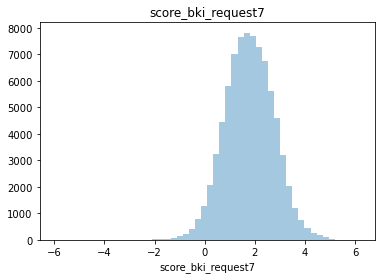

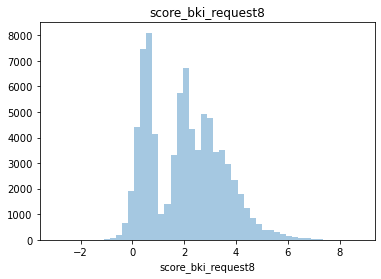

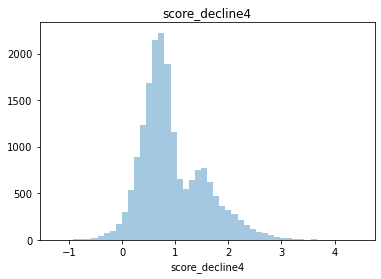

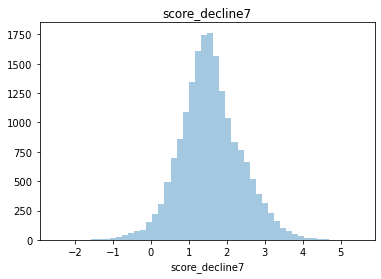

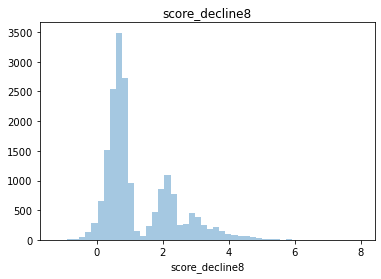

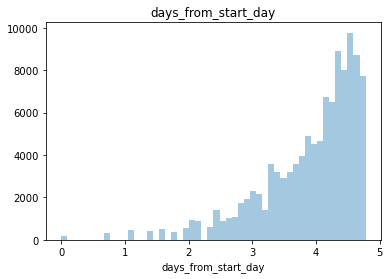

In [362]:
for i in num_cols:
    plt.figure()
    sns.distplot(scor[i][scor[i] > 0].apply(lambda x: math.log(x)), kde = False, rug=False)
    plt.title(i)
    plt.show()

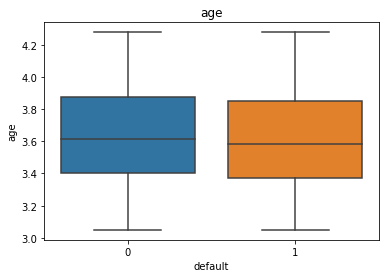

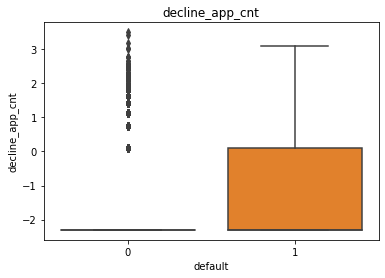

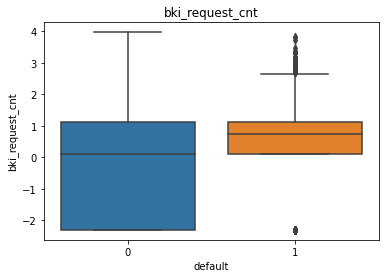

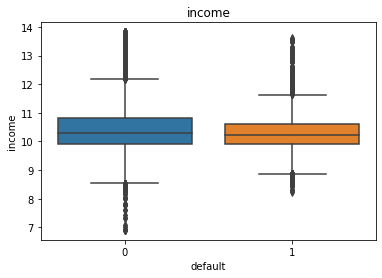

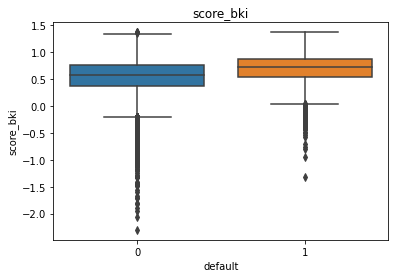

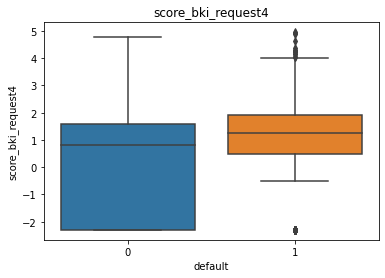

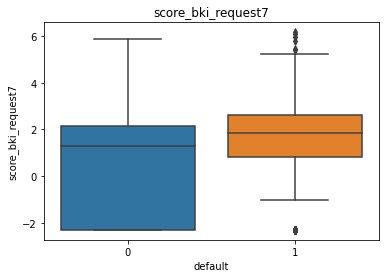

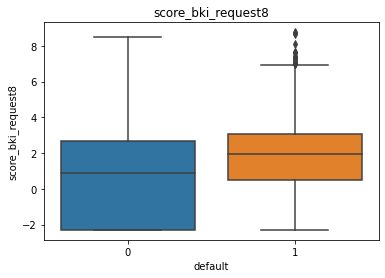

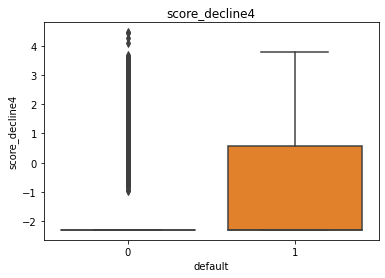

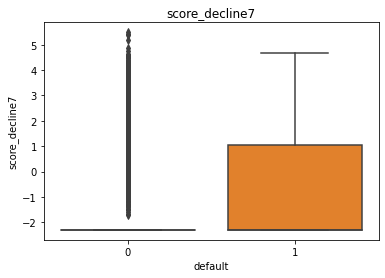

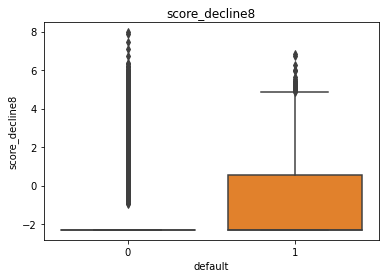

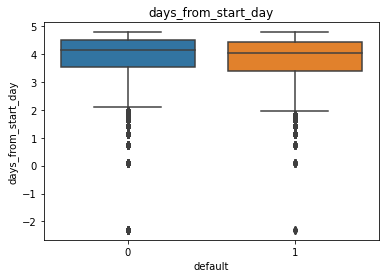

In [363]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x = scor.default, y = scor[i].apply(lambda x: math.log(abs(x+0.1))))
    plt.title(i)
    plt.show()

In [364]:
def outliers_iqr(x):
    ''' found outliers '''
    quartile_1, quartile_3 = np.percentile(x, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)    
    return np.where((x > upper_bound) | (x < lower_bound))[0]

Выведем на экран количество выбросов по межквартильному размаху. 

In [365]:
for i in num_cols_short:
    print(i, len(outliers_iqr(scor[i])))

age 0
decline_app_cnt 18677
bki_request_cnt 2636
income 7000
score_bki 518
days_from_start_day 0


По межквартильному размаху выбросов оказалось очень много. Имеет смысл ввести эмпирические границы, чтобы отсечь далекие правые хвосты в данных. Однако это ухудшило оценку и в дальнейшем не использовалось.

In [366]:
#print("количество отсекаемых выбросов: ",
#      len(scor[scor['decline_app_cnt'] > 10]), len(scor[scor['bki_request_cnt'] > 25]), 
#      len(scor[scor['score_bki'] > 3.5]))

In [367]:
#scor = scor.drop(scor[scor['decline_app_cnt'] > 10].index)
#scor = scor.drop(scor[scor['bki_request_cnt'] > 25].index)
#scor = scor.drop(scor[scor['score_bki'] > 3.5].index)

Посмотрим корреляцию численных признаков между собой

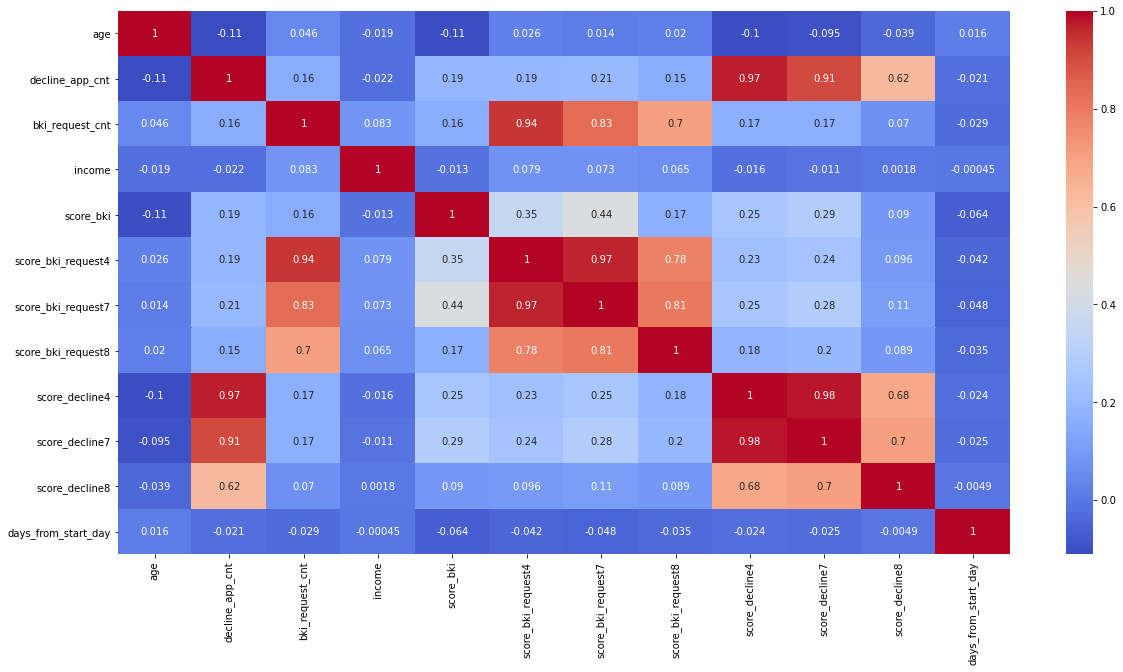

In [368]:
correlation = scor[scor['sample'] == 1][num_cols].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Гистограммы и boxplot много нового не дали. Heatmap показывает, что новый признак 'score_bki' не скоррелирован со старыми. У полиномиальных есть корреляция с исходными и между собой.

Значимость числовых признаков для целевой по f_classif (линейная зависимость)

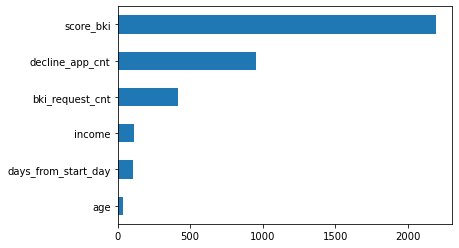

In [369]:
imp_num = Series(f_classif(scor[num_cols_short], scor['default'])[0], index = num_cols_short)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

 То же с полиномиальными признаками

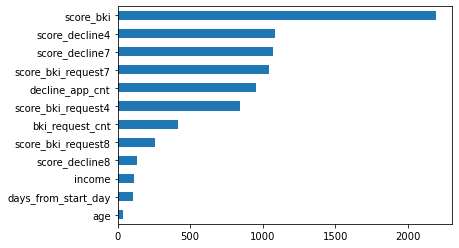

In [370]:
imp_num = Series(f_classif(scor[num_cols], scor['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

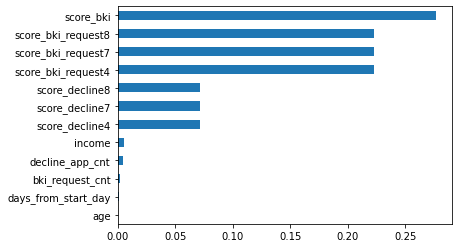

In [371]:
# Значимость числовых по mutual_info_classif
imp_cat = Series(mutual_info_classif(scor[num_cols], scor['default'],
                                     discrete_features =True), index = num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Вывод: новый числовой признак 'score_bki' оказался самым значимым для целевой переменной.

In [372]:
# Стандартизация числовых признаков
scor[num_cols] = StandardScaler().fit_transform(scor[num_cols])

# 3.2 Обработка бинарных признаков

In [373]:
bin_cols

['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

In [374]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    scor[column] = label_encoder.fit_transform(scor[column])

# 3.3 Обработка категориальных признаков

In [375]:
cat_cols

['education',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'region_rating',
 'app_weekday']

Из категориальных только 'education' не цифровой, преобразуем его

In [376]:
edu_dict = {'SCH': 0, 'GRD': 1, 'UGR': 2, 'PGR': 3, 'ACD': 4}
scor['education'] = scor['education'].replace(to_replace=edu_dict)

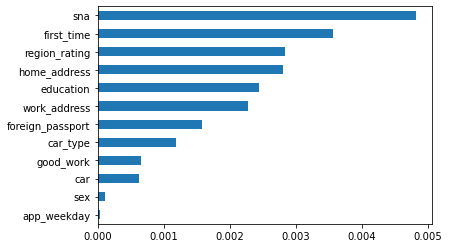

In [377]:
# Значимость категориальных и бинарных признаков по mutual_info_classif
imp_cat = Series(mutual_info_classif(scor[bin_cols + cat_cols], scor['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

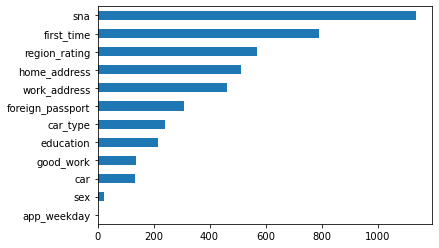

In [378]:
# Значимость категориальных и бинарных признаков по f_classif
imp_num = Series(f_classif(scor[bin_cols + cat_cols], scor['default'])[0], index = bin_cols + cat_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Вывод: новые категориальные признаки  'sna', 'first_time', 'region_rating' оказались в лидерах по значимости. Созданный 'app_weekday' получил низшую значимость по обеим оценкам.

Разбиваем категориальные на dummy

In [379]:
scor = pd.get_dummies(scor, columns = cat_cols , prefix_sep = "_")

In [380]:
#scor = scor.drop(['client_id', 'app_date', 'app_datetime'], axis=1)

In [381]:
cat_cols_dummy = ['education_0','education_1', 'education_2', 'education_3', 'education_4',
                  'home_address_1', 'home_address_2', 'home_address_3',
                  'work_address_1', 'work_address_2', 'work_address_3',
                  'sna_1', 'sna_2', 'sna_3', 'sna_4', 
                  'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4', 
                  'region_rating_20', 'region_rating_30', 'region_rating_40', 
                  'region_rating_50', 'region_rating_60', 'region_rating_70', 'region_rating_80', 
                  'app_weekday_0', 'app_weekday_1', 'app_weekday_2', 'app_weekday_3', 'app_weekday_4',
                  'app_weekday_5', 'app_weekday_6']

# Разбиение датафрейма

Выделим тестовую часть

In [382]:
train_data = scor.query('sample == 1').drop(['sample'], axis=1)
test_data = scor.query('sample == 0').drop(['sample'], axis=1)

y = train_data['default']            # наш таргет
X = train_data.drop(['default'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает до отправки submissiona на kaggle.

In [383]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [384]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 54), (73799, 54), (73799, 53), (59039, 53), (14760, 53))

In [385]:
# Объединяем
X = np.hstack([scor[num_cols].values, scor[bin_cols].values, scor[cat_cols_dummy].values])
Y = scor['default'].values

In [386]:
# Разделяем для обучения
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [387]:
# Запускаем логистическую регрессию
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
display(f1_score(y_test, y_pred).round(4))
display(confusion_matrix(y_test,y_pred,normalize=None))

0.0043

array([[20178,    10],
       [ 1838,     4]])

Строим ROC-curve и считаем ROC AUC

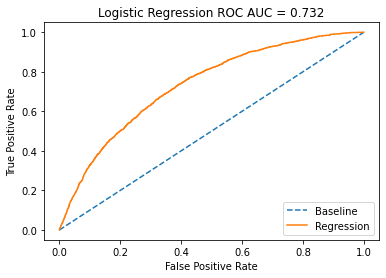

In [388]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Гиперпараметры

Попробуем подобрать гиперпараметры для лог. регрессии перебором с помощью GridSearchCV. Используем значение кросс-валидации 5 и ограниченное число параметров из-за долгого времени вычислений.

In [389]:
parameters = { 'penalty': ['l1', 'l2'], 
               'C': np.logspace(-1, 3, 10), 
               'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],               
               'max_iter': [300],
               'tol':[1e-2]}
grid = GridSearchCV(model, parameters,  scoring='f1', n_jobs=-1, cv=5)
grid.fit(X_train, y_train)
grid.best_params_

{'C': 2.1544346900318834,
 'max_iter': 300,
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 0.01}

In [390]:
# Запускаем логистическую регрессию с этими параметрами
model_par = LogisticRegression(C=2.1544, penalty='l1', solver='liblinear', random_state=42, max_iter=300)
model_par.fit(X_train, y_train)
y_pred = model_par.predict(X_test)
display(f1_score(y_test, y_pred).round(4))
display(confusion_matrix(y_test,y_pred,normalize=None))

0.0043

array([[20179,     9],
       [ 1838,     4]])

Нащупать улучшение метрик не получилось. Запустим еще LogisticRegressionCV - логистическую регрессию с кросс-валидацией

In [391]:
model_LCV = LogisticRegressionCV(
        Cs=np.logspace(-1, 3, 10),
        penalty='l1',
        scoring='roc_auc',
        cv=10,
        random_state=42,
        max_iter=300,
        fit_intercept=False,
        solver='liblinear',
        tol=1e-2)

model_LCV.fit(X_train, y_train)

print ('Max roc_auc:', model_LCV.scores_[1].max())

Max roc_auc: 0.7384505078498926


0.0032

array([[20181,     7],
       [ 1839,     3]])

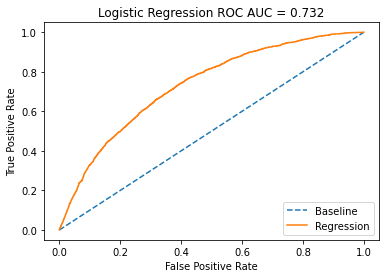

In [392]:
y_pred = model_LCV.predict(X_test)
display(f1_score(y_test, y_pred).round(4))
display(confusion_matrix(y_test,y_pred,normalize=None))
probs = model_LCV.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

С LogisticRegressionCV получаем совсем небольшое улучшение метрик.

# Submission

In [399]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539


In [393]:
train_data = scor.query('sample == 1').drop(['sample'], axis=1)
test_data = scor.query('sample == 0').drop(['sample'], axis=1)

In [394]:
X_train=train_data.drop(['default', 'app_date', 'app_datetime', 'client_id'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default', 'app_date', 'app_datetime', 'client_id'], axis=1)
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 54), (73799, 54), (73799, 50), (73799,), (36349, 50))

In [395]:
model_LCV.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03]),
                     cv=10, fit_intercept=False, max_iter=300, penalty='l1',
                     random_state=42, scoring='roc_auc', solver='liblinear',
                     tol=0.01)

In [400]:
y_pred_prob = model_LCV.predict_proba(X_test)[:,1]


submission = pd.DataFrame(scor_test.client_id)
submission['default']=y_pred_prob
submission.to_csv('submission.csv', index=False)